In [1]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import PIL
import PIL.Image
import cv2

In [2]:
# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


In [3]:
'''

Lets define some dir to save iamges.

'''

from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
path = "./img_align_celeba"
data_dir = pathlib.Path(path)

# Lets check quantity
image_count = len(list(data_dir.glob('*.jpg')))
print('We have', image_count, 'images.')

We have 202599 images.


In [5]:
# Get all paths
all_paths = [str(x) for x in list(data_dir.glob('*.jpg'))]

In [6]:
train_path = all_paths[:int(image_count * 0.8)]
val_path = all_paths[int(image_count * 0.8): int(image_count * 0.9)]
test_path = all_paths[int(image_count * 0.9):]

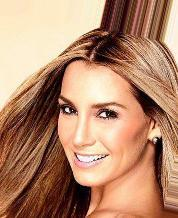

In [7]:
# Sanity check!
PIL.Image.open(train_path[0])

In [10]:
# Instanciate tf datasets
ds_train_path = tf.data.Dataset.from_tensor_slices(train_path)
ds_val_path = tf.data.Dataset.from_tensor_slices(val_path)
ds_test_path = tf.data.Dataset.from_tensor_slices(test_path)

In [11]:
'''

Open all images and resize.

'''

def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=2):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    return tf.image.resize(x, [128, 128]) / 255.

ds_train = ds_train_path.map(
    lambda x: resize_image(open_image(x))
)

ds_val = ds_val_path.map(
    lambda x: resize_image(open_image(x))
)

ds_test = ds_test_path.map(
    lambda x: resize_image(open_image(x))
)

### Load Pre-trained model

In [12]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [13]:
custom_objects = {'Sampling': Sampling}

In [14]:
'''

Pre-trained models - Instructions about training you can find in another file

'''

variational_ae = keras.models.load_model('my_vae_celeba/autoencoder/vae_autoencoder.keras', custom_objects=custom_objects)
variational_encoder = keras.models.load_model('my_vae_celeba/encoder/vae_encoder.keras', custom_objects=custom_objects)
variational_decoder = keras.models.load_model('my_vae_celeba/decoder/vae_decoder.keras', custom_objects=custom_objects)

In [15]:
'''

Slice ds_train in batches

'''


dataset_train = ds_train.batch(128, drop_remainder=True).prefetch(1)
dataset_val = ds_val.batch(128, drop_remainder=True).prefetch(1)

In [16]:
for j in dataset_train.take(1):
    print(j[1].shape)

(128, 128, 128, 3)


In [17]:
'''

Define util functions to show images.

'''

from IPython.display import clear_output

def plot_multiple_images_without_k(images, n_cols=None, output_neural=False):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        
        if output_neural:
            plt.imshow(image, cmap="binary")
            clear_output()
        else:
            plt.imshow(image, cmap="binary")
        plt.axis("off")

def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")

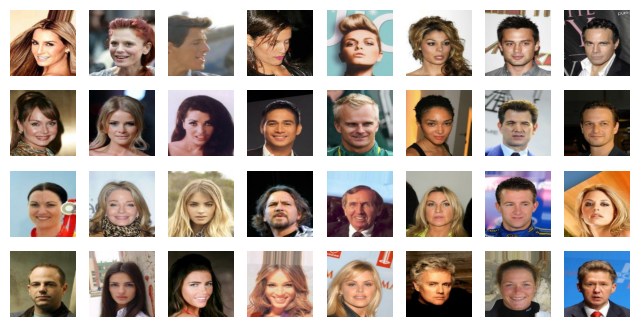

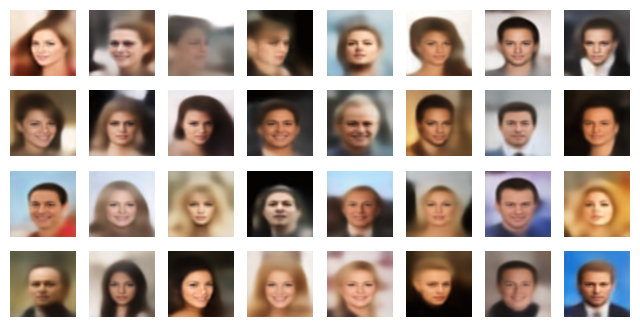

In [18]:
'''

Let's check sanity with models.

'''

for X_ds in dataset_train.take(1):
    plot_multiple_images_without_k(X_ds[0][:32], 8)
    plot_multiple_images_without_k(variational_ae(X_ds[0][:32]), 8, output_neural=True)

### Transitions

In [19]:
A = variational_encoder(X_ds[0][6][tf.newaxis])[0]
B = variational_encoder(X_ds[0][31][tf.newaxis])[0]

In [20]:
r = ((B - A) / tf.norm(B - A)).numpy()[0]
o = A.numpy()[0]
d = np.linspace(0, tf.norm(B - A), 200)

In [21]:
(o + np.random.choice(d) * r).reshape(1, -1)

array([[ 1.84934273e-01,  3.44340444e-01,  4.75199193e-01,
        -1.01064134e+00, -1.23508811e-01, -1.09012449e+00,
        -5.66924572e-01,  1.02931619e+00, -1.75632596e-01,
         7.36066461e-01, -4.17946100e-01,  6.47664189e-01,
        -3.04164946e-01,  1.40794814e-01,  5.79223156e-01,
         1.73845458e+00, -1.10116315e+00, -1.37660682e-01,
        -9.16070044e-01,  8.87221158e-01,  1.52897239e-01,
         8.98301601e-04,  9.81336355e-01, -1.59294859e-01,
        -7.13809073e-01, -6.48784876e-01,  2.35414326e-01,
         8.95502269e-02, -6.65172935e-03,  2.31863379e-01,
         1.07246685e+00,  9.42084551e-01, -9.72309828e-01,
         1.00986016e+00, -2.47509971e-01, -1.84324086e-02,
        -1.50319541e+00,  2.80194759e-01,  1.41116524e+00,
        -6.71615601e-01, -1.12448350e-01, -3.67791653e-02,
         1.44982964e-01,  4.88241792e-01,  1.06829154e+00,
         4.37081903e-01,  6.47687435e-01, -1.32942224e+00,
        -5.51797688e-01,  7.83704102e-01,  1.08716965e-0

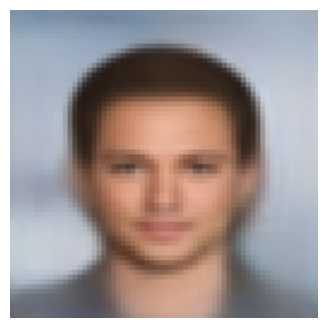

In [22]:
plot_multiple_images(variational_decoder((o + np.random.choice(d) * r).reshape(1, -1)), k=4)

In [36]:
cms_regular = [variational_encoder(X_ds[0][i][tf.newaxis])[0].numpy()[0] for i in range(6, 16)]

In [37]:
np.array(cms_regular).shape

(10, 64)

In [45]:
many = []
for i in range(10):#range(4, len(cms) - 5):
    A, B = cms_regular[i - 1].copy(), cms_regular[i].copy()
    versor = (B - A) / np.linalg.norm(B - A)
    d = np.linspace(0, np.linalg.norm(B - A), 20)
    for i in range(20):
        row = A + d[i] * versor
        many.append(row.copy())

many = tf.convert_to_tensor(tf.squeeze(np.array(many)))
images = variational_decoder(many).numpy()
images_converted_regular = []

for x in images:
    new_x = ((x - x.min()) / (x - x.min()).max()) * 255
    new_x = new_x.astype(np.uint8)
    images_converted_regular.append(new_x)

images_converted_regular = np.array(images_converted_regular)
# np.array([(img * 255).astype(np.int32) for img in images])

frames_regular = []
for i in range(len(images_converted_regular)):
    image = images_converted_regular[i].copy()
    # image = cv2.resize(image, (128, 128)) 
    # rgb_image = np.zeros((128, 128, 3), dtype=np.uint8)
    # rgb_image[:, :, 0] = image  # R channel
    # rgb_image[:, :, 1] = image  # G channel
    # rgb_image[:, :, 2] = image  # B channel
    frames_regular.append(image)
frames_regular = np.array(frames_regular)

In [46]:
frames_regular.shape

(200, 128, 128, 3)

In [47]:
import imageio

In [48]:

# Convert to gif using the imageio.mimsave method
imageio.mimsave('output_gif_regular.gif', frames_regular, fps=12)